# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Fri Apr 28 12:01:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:21:00.0  On |                  Off |
| 41%   39C    P8    20W / 140W |    609MiB / 16376MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

In [5]:
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return ( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) 
    
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) + dim * dim * y[(dim+1):(2*dim+1)].sum(dim=0) / 2 )

def phi_example(x, coordinate=0):
    return torch.exp( T + x.sum(axis=0) / dim ) / (1 + torch.exp( T + x.sum(axis=0) / dim ) )
        
def exact_example(t, x, T):
    xi = t + x.sum(axis=0) / dim 
    return 1 / (1 + np.exp( - xi ) )

t_lo, x_lo, x_hi = 0., -5., 5.
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

T = 0.1
dim = 5
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 6.42E-04; L2 error: 9.03E-07; rel error: 1.31E-03.
fdb runtime: 6 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 178 seconds; L1 error: 1.32E-03; L2 error: 1.99E-06; rel error: 3.12E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 140 seconds; L1 error: 9.87E-04; L2 error: 1.62E-06; rel error: 2.45E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 4.69E-04; L2 error: 3.46E-07; rel error: 9.94E-04.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 176 seconds; L1 error: 1.91E-03; L2 error: 6.73E-06; rel error: 5.29E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 8.09E-04; L2 error: 1.15E-06; rel error: 1.51E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.01E-03; L2 error: 1.83E-06; rel error: 2.05E-03.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 179 seconds; L1 error: 7.69E-04; L2 error: 1.04E-06; rel error: 1.95E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 1.66E-03; L2 error: 3.72E-06; rel error: 3.62E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 7.04E-04; L2 error: 7.35E-07; rel error: 1.42E-03.
fdb runtime: 13 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 181 seconds; L1 error: 1.03E-03; L2 error: 1.31E-06; rel error: 2.00E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 139 seconds; L1 error: 1.26E-03; L2 error: 2.72E-06; rel error: 2.94E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 4.57E-04; L2 error: 3.15E-07; rel error: 9.44E-04.
fdb runtime: 9 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 179 seconds; L1 error: 1.07E-03; L2 error: 1.75E-06; rel error: 2.69E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 142 seconds; L1 error: 6.63E-04; L2 error: 6.01E-07; rel error: 1.45E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 6.39E-04; L2 error: 7.83E-07; rel error: 1.24E-03.
fdb runtime: 12 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 187 seconds; L1 error: 9.95E-04; L2 error: 2.01E-06; rel error: 1.81E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 139 seconds; L1 error: 1.61E-03; L2 error: 3.20E-06; rel error: 3.56E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 7.35E-04; L2 error: 8.45E-07; rel error: 1.62E-03.
fdb runtime: 8 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 184 seconds; L1 error: 2.26E-03; L2 error: 7.07E-06; rel error: 5.66E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 143 seconds; L1 error: 1.79E-03; L2 error: 4.01E-06; rel error: 3.75E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 7.32E-04; L2 error: 8.80E-07; rel error: 1.61E-03.
fdb runtime: 10 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 185 seconds; L1 error: 4.44E-03; L2 error: 2.16E-05; rel error: 9.19E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 135 seconds; L1 error: 1.75E-03; L2 error: 3.43E-06; rel error: 3.74E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 6.45E-04; L2 error: 6.41E-07; rel error: 1.38E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 182 seconds; L1 error: 7.48E-04; L2 error: 7.51E-07; rel error: 1.82E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 144 seconds; L1 error: 5.86E-04; L2 error: 4.95E-07; rel error: 1.24E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 68 seconds; L1 error: 8.57E-04; L2 error: 1.01E-06; rel error: 1.98E-03.
fdb runtime: 8 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 177 seconds; L1 error: 1.47E-03; L2 error: 2.87E-06; rel error: 3.70E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 138 seconds; L1 error: 9.09E-04; L2 error: 1.18E-06; rel error: 2.01E-03.




######## Summary for deep branching method
runtime:        73
fdb runtime:    9
total runtime:  82
mean L1 error:  6.89E-04
std L1 error:   1.57E-04
mean L2 error:  8.29E-07
std L2 error:   4.00E-07
mean rel error: 1.46E-03
std rel error:  3.52E-04


######## Summary for deep galerkin method
runtime:        181
mean L1 error:  1.60E-03
std L1 error:   1.05E-03
mean L2 error:  4.71E-06
std L2 error:   6.02E-06
mean rel error: 3.72E-03
std rel error:  2.26E-03


######## Summary for deep BSDE method
runtime:        141
mean L1 error:  1.20E-03
std L1 e

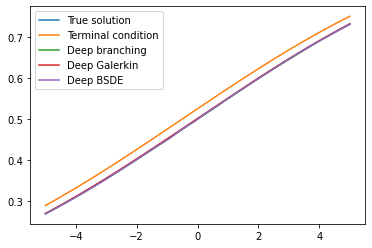

In [6]:
T=0.0001
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 6.24E-04; L2 error: 8.96E-07; rel error: 1.31E-03.
fdb runtime: 6 seconds; total runtime: 75 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 185 seconds; L1 error: 1.28E-03; L2 error: 1.88E-06; rel error: 3.03E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 141 seconds; L1 error: 1.19E-03; L2 error: 1.82E-06; rel error: 2.83E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 4.71E-04; L2 error: 3.62E-07; rel error: 9.83E-04.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 180 seconds; L1 error: 1.86E-03; L2 error: 6.37E-06; rel error: 5.15E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 141 seconds; L1 error: 6.07E-04; L2 error: 5.20E-07; rel error: 1.19E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 1.02E-03; L2 error: 1.87E-06; rel error: 2.07E-03.
fdb runtime: 9 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 186 seconds; L1 error: 7.50E-04; L2 error: 1.01E-06; rel error: 1.92E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 141 seconds; L1 error: 1.57E-03; L2 error: 3.13E-06; rel error: 3.75E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 8.44E-04; L2 error: 9.48E-07; rel error: 1.69E-03.
fdb runtime: 13 seconds; total runtime: 89 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 185 seconds; L1 error: 1.00E-03; L2 error: 1.25E-06; rel error: 1.95E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 142 seconds; L1 error: 1.29E-03; L2 error: 2.15E-06; rel error: 2.80E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 4.09E-04; L2 error: 2.50E-07; rel error: 8.14E-04.
fdb runtime: 8 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 190 seconds; L1 error: 1.05E-03; L2 error: 1.65E-06; rel error: 2.62E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 147 seconds; L1 error: 5.66E-04; L2 error: 4.73E-07; rel error: 1.23E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 6.62E-04; L2 error: 8.25E-07; rel error: 1.30E-03.
fdb runtime: 11 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 189 seconds; L1 error: 9.92E-04; L2 error: 2.03E-06; rel error: 1.80E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 148 seconds; L1 error: 1.26E-03; L2 error: 2.07E-06; rel error: 2.98E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 7.64E-04; L2 error: 9.29E-07; rel error: 1.68E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 186 seconds; L1 error: 2.20E-03; L2 error: 6.78E-06; rel error: 5.52E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 146 seconds; L1 error: 1.96E-03; L2 error: 5.05E-06; rel error: 4.75E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 7.11E-04; L2 error: 8.36E-07; rel error: 1.57E-03.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 181 seconds; L1 error: 4.25E-03; L2 error: 1.99E-05; rel error: 8.77E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 141 seconds; L1 error: 1.83E-03; L2 error: 5.02E-06; rel error: 4.03E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 6.49E-04; L2 error: 6.60E-07; rel error: 1.40E-03.
fdb runtime: 8 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 192 seconds; L1 error: 7.49E-04; L2 error: 7.53E-07; rel error: 1.82E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 147 seconds; L1 error: 8.83E-04; L2 error: 1.12E-06; rel error: 1.76E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 8.25E-04; L2 error: 9.33E-07; rel error: 1.89E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 191 seconds; L1 error: 1.49E-03; L2 error: 2.97E-06; rel error: 3.76E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 146 seconds; L1 error: 1.43E-03; L2 error: 2.55E-06; rel error: 2.93E-03.




######## Summary for deep branching method
runtime:        73
fdb runtime:    9
total runtime:  82
mean L1 error:  6.98E-04
std L1 error:   1.71E-04
mean L2 error:  8.51E-07
std L2 error:   4.12E-07
mean rel error: 1.47E-03
std rel error:  3.70E-04


######## Summary for deep galerkin method
runtime:        187
mean L1 error:  1.56E-03
std L1 error:   1.00E-03
mean L2 error:  4.46E-06
std L2 error:   5.54E-06
mean rel error: 3.63E-03
std rel error:  2.15E-03


######## Summary for deep BSDE method
runtime:        144
mean L1 error:  1.26E-03
std L1 e

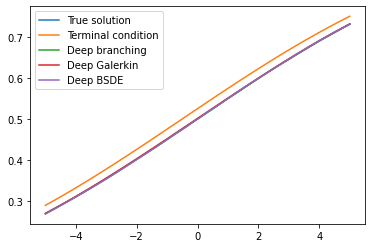

In [7]:
T=0.0125
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 7.11E-04; L2 error: 1.02E-06; rel error: 1.60E-03.
fdb runtime: 6 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 187 seconds; L1 error: 1.23E-03; L2 error: 1.78E-06; rel error: 2.93E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 144 seconds; L1 error: 7.35E-04; L2 error: 8.12E-07; rel error: 1.91E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 6.70E-04; L2 error: 6.18E-07; rel error: 1.50E-03.
fdb runtime: 9 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 186 seconds; L1 error: 1.82E-03; L2 error: 6.00E-06; rel error: 5.01E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 140 seconds; L1 error: 8.44E-04; L2 error: 1.01E-06; rel error: 1.87E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 80 seconds; L1 error: 1.03E-03; L2 error: 1.91E-06; rel error: 2.09E-03.
fdb runtime: 8 seconds; total runtime: 88 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 192 seconds; L1 error: 7.34E-04; L2 error: 9.83E-07; rel error: 1.89E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 140 seconds; L1 error: 1.54E-03; L2 error: 3.31E-06; rel error: 3.27E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 8.53E-04; L2 error: 9.92E-07; rel error: 1.71E-03.
fdb runtime: 12 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 185 seconds; L1 error: 9.78E-04; L2 error: 1.20E-06; rel error: 1.89E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 145 seconds; L1 error: 1.43E-03; L2 error: 2.70E-06; rel error: 3.20E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 6.92E-04; L2 error: 7.84E-07; rel error: 1.49E-03.
fdb runtime: 9 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 184 seconds; L1 error: 1.02E-03; L2 error: 1.56E-06; rel error: 2.55E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 142 seconds; L1 error: 6.07E-04; L2 error: 5.16E-07; rel error: 1.22E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 9.14E-04; L2 error: 1.49E-06; rel error: 1.89E-03.
fdb runtime: 11 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 181 seconds; L1 error: 9.89E-04; L2 error: 2.05E-06; rel error: 1.79E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 142 seconds; L1 error: 1.69E-03; L2 error: 3.94E-06; rel error: 3.83E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 7.63E-04; L2 error: 9.85E-07; rel error: 1.67E-03.
fdb runtime: 8 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 193 seconds; L1 error: 2.13E-03; L2 error: 6.47E-06; rel error: 5.37E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 1.77E-03; L2 error: 4.41E-06; rel error: 4.44E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 6.62E-04; L2 error: 7.57E-07; rel error: 1.52E-03.
fdb runtime: 10 seconds; total runtime: 84 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 183 seconds; L1 error: 4.06E-03; L2 error: 1.83E-05; rel error: 8.34E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 143 seconds; L1 error: 1.77E-03; L2 error: 3.47E-06; rel error: 4.08E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 6.64E-04; L2 error: 7.44E-07; rel error: 1.42E-03.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 184 seconds; L1 error: 7.49E-04; L2 error: 7.54E-07; rel error: 1.82E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 139 seconds; L1 error: 5.94E-04; L2 error: 5.31E-07; rel error: 1.31E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 8.59E-04; L2 error: 1.19E-06; rel error: 1.91E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 186 seconds; L1 error: 1.51E-03; L2 error: 3.07E-06; rel error: 3.81E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 141 seconds; L1 error: 8.84E-04; L2 error: 1.42E-06; rel error: 1.73E-03.




######## Summary for deep branching method
runtime:        73
fdb runtime:    9
total runtime:  82
mean L1 error:  7.82E-04
std L1 error:   1.20E-04
mean L2 error:  1.05E-06
std L2 error:   3.72E-07
mean rel error: 1.68E-03
std rel error:  2.08E-04


######## Summary for deep galerkin method
runtime:        186
mean L1 error:  1.52E-03
std L1 error:   9.50E-04
mean L2 error:  4.22E-06
std L2 error:   5.07E-06
mean rel error: 3.54E-03
std rel error:  2.04E-03


######## Summary for deep BSDE method
runtime:        142
mean L1 error:  1.19E-03
std L1 e

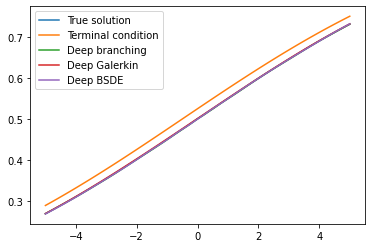

In [8]:
T=0.0250
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 9.47E-04; L2 error: 1.62E-06; rel error: 2.27E-03.
fdb runtime: 6 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 186 seconds; L1 error: 1.19E-03; L2 error: 1.67E-06; rel error: 2.83E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 8.73E-04; L2 error: 1.05E-06; rel error: 1.88E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.04E-03; L2 error: 1.79E-06; rel error: 2.47E-03.
fdb runtime: 10 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 180 seconds; L1 error: 1.77E-03; L2 error: 5.62E-06; rel error: 4.86E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 148 seconds; L1 error: 6.96E-04; L2 error: 8.59E-07; rel error: 1.72E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 1.08E-03; L2 error: 1.99E-06; rel error: 2.19E-03.
fdb runtime: 9 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 184 seconds; L1 error: 7.23E-04; L2 error: 9.72E-07; rel error: 1.87E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 143 seconds; L1 error: 1.61E-03; L2 error: 3.52E-06; rel error: 3.81E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 8.96E-04; L2 error: 1.04E-06; rel error: 1.88E-03.
fdb runtime: 12 seconds; total runtime: 84 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 187 seconds; L1 error: 9.53E-04; L2 error: 1.14E-06; rel error: 1.84E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 146 seconds; L1 error: 9.46E-04; L2 error: 1.62E-06; rel error: 2.36E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.04E-03; L2 error: 2.01E-06; rel error: 2.35E-03.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 181 seconds; L1 error: 9.93E-04; L2 error: 1.48E-06; rel error: 2.48E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 147 seconds; L1 error: 8.08E-04; L2 error: 1.42E-06; rel error: 1.78E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 1.19E-03; L2 error: 2.13E-06; rel error: 2.65E-03.
fdb runtime: 11 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 175 seconds; L1 error: 9.87E-04; L2 error: 2.07E-06; rel error: 1.78E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 142 seconds; L1 error: 1.42E-03; L2 error: 2.72E-06; rel error: 3.50E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 7.66E-04; L2 error: 1.07E-06; rel error: 1.70E-03.
fdb runtime: 8 seconds; total runtime: 74 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 184 seconds; L1 error: 2.07E-03; L2 error: 6.18E-06; rel error: 5.23E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 1.47E-03; L2 error: 2.77E-06; rel error: 2.99E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 8.33E-04; L2 error: 1.25E-06; rel error: 2.04E-03.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 177 seconds; L1 error: 3.86E-03; L2 error: 1.67E-05; rel error: 7.91E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 149 seconds; L1 error: 1.71E-03; L2 error: 4.91E-06; rel error: 4.59E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 7.55E-04; L2 error: 9.65E-07; rel error: 1.59E-03.
fdb runtime: 8 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 185 seconds; L1 error: 7.48E-04; L2 error: 7.53E-07; rel error: 1.82E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 136 seconds; L1 error: 7.51E-04; L2 error: 8.85E-07; rel error: 1.57E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.21E-03; L2 error: 3.10E-06; rel error: 2.66E-03.
fdb runtime: 7 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 182 seconds; L1 error: 1.53E-03; L2 error: 3.18E-06; rel error: 3.87E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 150 seconds; L1 error: 1.19E-03; L2 error: 1.73E-06; rel error: 2.54E-03.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  81
mean L1 error:  9.75E-04
std L1 error:   1.55E-04
mean L2 error:  1.70E-06
std L2 error:   6.24E-07
mean rel error: 2.18E-03
std rel error:  3.54E-04


######## Summary for deep galerkin method
runtime:        182
mean L1 error:  1.48E-03
std L1 error:   8.99E-04
mean L2 error:  3.98E-06
std L2 error:   4.62E-06
mean rel error: 3.45E-03
std rel error:  1.93E-03


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  1.15E-03
std L1 e

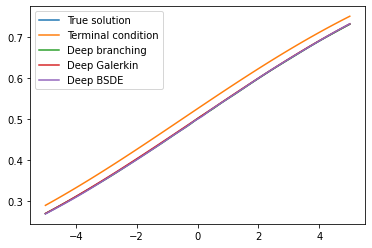

In [9]:
T=0.0375
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 68 seconds; L1 error: 1.08E-03; L2 error: 2.23E-06; rel error: 2.75E-03.
fdb runtime: 6 seconds; total runtime: 74 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 187 seconds; L1 error: 1.14E-03; L2 error: 1.56E-06; rel error: 2.73E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 150 seconds; L1 error: 1.32E-03; L2 error: 2.64E-06; rel error: 2.78E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.65E-03; L2 error: 5.45E-06; rel error: 4.03E-03.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 195 seconds; L1 error: 1.72E-03; L2 error: 5.22E-06; rel error: 4.69E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 147 seconds; L1 error: 1.19E-03; L2 error: 1.75E-06; rel error: 2.48E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.17E-03; L2 error: 2.21E-06; rel error: 2.39E-03.
fdb runtime: 9 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 189 seconds; L1 error: 7.17E-04; L2 error: 9.71E-07; rel error: 1.87E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 1.63E-03; L2 error: 3.70E-06; rel error: 3.58E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 9.53E-04; L2 error: 1.15E-06; rel error: 2.07E-03.
fdb runtime: 13 seconds; total runtime: 90 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 190 seconds; L1 error: 9.28E-04; L2 error: 1.09E-06; rel error: 1.79E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 144 seconds; L1 error: 9.83E-04; L2 error: 1.37E-06; rel error: 2.10E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.40E-03; L2 error: 5.01E-06; rel error: 3.01E-03.
fdb runtime: 8 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 186 seconds; L1 error: 9.67E-04; L2 error: 1.40E-06; rel error: 2.41E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 143 seconds; L1 error: 1.31E-03; L2 error: 2.53E-06; rel error: 2.88E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 1.58E-03; L2 error: 3.76E-06; rel error: 3.69E-03.
fdb runtime: 11 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 182 seconds; L1 error: 9.85E-04; L2 error: 2.09E-06; rel error: 1.77E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 148 seconds; L1 error: 1.44E-03; L2 error: 3.06E-06; rel error: 3.64E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 68 seconds; L1 error: 8.19E-04; L2 error: 1.28E-06; rel error: 1.85E-03.
fdb runtime: 8 seconds; total runtime: 76 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 184 seconds; L1 error: 2.01E-03; L2 error: 5.90E-06; rel error: 5.10E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 134 seconds; L1 error: 1.60E-03; L2 error: 3.57E-06; rel error: 3.58E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 1.32E-03; L2 error: 2.79E-06; rel error: 3.13E-03.
fdb runtime: 10 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 180 seconds; L1 error: 3.67E-03; L2 error: 1.53E-05; rel error: 7.49E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 142 seconds; L1 error: 1.63E-03; L2 error: 3.61E-06; rel error: 4.13E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 8.91E-04; L2 error: 1.35E-06; rel error: 1.85E-03.
fdb runtime: 8 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 184 seconds; L1 error: 7.46E-04; L2 error: 7.50E-07; rel error: 1.81E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 136 seconds; L1 error: 8.64E-04; L2 error: 1.07E-06; rel error: 1.84E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.80E-03; L2 error: 8.02E-06; rel error: 4.01E-03.
fdb runtime: 7 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 191 seconds; L1 error: 1.55E-03; L2 error: 3.28E-06; rel error: 3.92E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 142 seconds; L1 error: 1.02E-03; L2 error: 1.45E-06; rel error: 2.00E-03.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  81
mean L1 error:  1.27E-03
std L1 error:   3.21E-04
mean L2 error:  3.33E-06
std L2 error:   2.13E-06
mean rel error: 2.88E-03
std rel error:  7.98E-04


######## Summary for deep galerkin method
runtime:        187
mean L1 error:  1.44E-03
std L1 error:   8.47E-04
mean L2 error:  3.75E-06
std L2 error:   4.20E-06
mean rel error: 3.36E-03
std rel error:  1.82E-03


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  1.30E-03
std L1 e

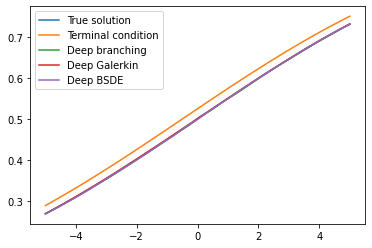

In [10]:
T=0.0500
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 1.35E-03; L2 error: 3.44E-06; rel error: 3.51E-03.
fdb runtime: 6 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 183 seconds; L1 error: 1.09E-03; L2 error: 1.46E-06; rel error: 2.62E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 142 seconds; L1 error: 8.92E-04; L2 error: 1.22E-06; rel error: 2.23E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 68 seconds; L1 error: 2.41E-03; L2 error: 1.33E-05; rel error: 5.96E-03.
fdb runtime: 9 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 189 seconds; L1 error: 1.66E-03; L2 error: 4.82E-06; rel error: 4.52E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 150 seconds; L1 error: 1.15E-03; L2 error: 1.60E-06; rel error: 2.44E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 9.91E-04; L2 error: 1.65E-06; rel error: 2.17E-03.
fdb runtime: 9 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 195 seconds; L1 error: 7.14E-04; L2 error: 9.80E-07; rel error: 1.87E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 142 seconds; L1 error: 1.85E-03; L2 error: 5.41E-06; rel error: 4.78E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 1.03E-03; L2 error: 1.42E-06; rel error: 2.31E-03.
fdb runtime: 12 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 182 seconds; L1 error: 9.05E-04; L2 error: 1.04E-06; rel error: 1.75E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 147 seconds; L1 error: 1.59E-03; L2 error: 3.20E-06; rel error: 3.44E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 78 seconds; L1 error: 1.97E-03; L2 error: 1.17E-05; rel error: 4.38E-03.
fdb runtime: 8 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 184 seconds; L1 error: 9.42E-04; L2 error: 1.32E-06; rel error: 2.34E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 146 seconds; L1 error: 7.16E-04; L2 error: 8.42E-07; rel error: 1.62E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 1.98E-03; L2 error: 6.27E-06; rel error: 4.83E-03.
fdb runtime: 11 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 178 seconds; L1 error: 9.84E-04; L2 error: 2.12E-06; rel error: 1.76E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 151 seconds; L1 error: 1.47E-03; L2 error: 3.90E-06; rel error: 3.96E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 9.45E-04; L2 error: 1.74E-06; rel error: 2.19E-03.
fdb runtime: 8 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 190 seconds; L1 error: 1.95E-03; L2 error: 5.62E-06; rel error: 4.96E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 1.93E-03; L2 error: 4.68E-06; rel error: 4.50E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.72E-03; L2 error: 5.24E-06; rel error: 4.22E-03.
fdb runtime: 10 seconds; total runtime: 84 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 182 seconds; L1 error: 3.48E-03; L2 error: 1.38E-05; rel error: 7.07E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 141 seconds; L1 error: 2.15E-03; L2 error: 6.27E-06; rel error: 5.28E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.07E-03; L2 error: 1.96E-06; rel error: 2.21E-03.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 189 seconds; L1 error: 7.43E-04; L2 error: 7.45E-07; rel error: 1.81E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 144 seconds; L1 error: 5.99E-04; L2 error: 5.00E-07; rel error: 1.21E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 2.61E-03; L2 error: 1.80E-05; rel error: 5.87E-03.
fdb runtime: 8 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 187 seconds; L1 error: 1.56E-03; L2 error: 3.38E-06; rel error: 3.98E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 142 seconds; L1 error: 1.93E-03; L2 error: 4.87E-06; rel error: 3.92E-03.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  80
mean L1 error:  1.61E-03
std L1 error:   5.85E-04
mean L2 error:  6.48E-06
std L2 error:   5.57E-06
mean rel error: 3.77E-03
std rel error:  1.43E-03


######## Summary for deep galerkin method
runtime:        186
mean L1 error:  1.40E-03
std L1 error:   7.97E-04
mean L2 error:  3.53E-06
std L2 error:   3.80E-06
mean rel error: 3.27E-03
std rel error:  1.71E-03


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  1.43E-03
std L1 e

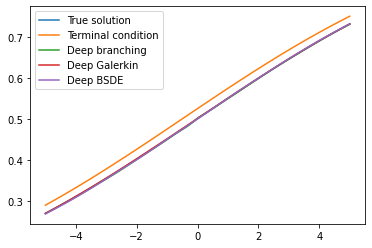

In [11]:
T=0.0625
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 1.91E-03; L2 error: 6.39E-06; rel error: 4.87E-03.
fdb runtime: 6 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 180 seconds; L1 error: 1.04E-03; L2 error: 1.36E-06; rel error: 2.52E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 1.23E-03; L2 error: 2.50E-06; rel error: 3.00E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 3.44E-03; L2 error: 2.96E-05; rel error: 8.60E-03.
fdb runtime: 10 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 182 seconds; L1 error: 1.60E-03; L2 error: 4.41E-06; rel error: 4.33E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 139 seconds; L1 error: 9.99E-04; L2 error: 1.58E-06; rel error: 2.07E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 1.20E-03; L2 error: 2.44E-06; rel error: 2.61E-03.
fdb runtime: 8 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 184 seconds; L1 error: 7.17E-04; L2 error: 1.00E-06; rel error: 1.88E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 135 seconds; L1 error: 1.59E-03; L2 error: 4.39E-06; rel error: 3.05E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 68 seconds; L1 error: 1.24E-03; L2 error: 2.14E-06; rel error: 2.80E-03.
fdb runtime: 12 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 181 seconds; L1 error: 8.82E-04; L2 error: 9.89E-07; rel error: 1.70E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 1.31E-03; L2 error: 2.94E-06; rel error: 3.34E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 2.73E-03; L2 error: 2.56E-05; rel error: 6.24E-03.
fdb runtime: 8 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 185 seconds; L1 error: 9.17E-04; L2 error: 1.25E-06; rel error: 2.27E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 143 seconds; L1 error: 8.85E-04; L2 error: 1.10E-06; rel error: 1.93E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.75E-03; L2 error: 1.23E-05; rel error: 6.73E-03.
fdb runtime: 11 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 188 seconds; L1 error: 9.79E-04; L2 error: 2.15E-06; rel error: 1.74E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 143 seconds; L1 error: 2.11E-03; L2 error: 7.19E-06; rel error: 5.47E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 1.16E-03; L2 error: 2.62E-06; rel error: 2.74E-03.
fdb runtime: 8 seconds; total runtime: 75 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 186 seconds; L1 error: 1.90E-03; L2 error: 5.35E-06; rel error: 4.83E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 145 seconds; L1 error: 1.90E-03; L2 error: 4.61E-06; rel error: 3.66E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 2.26E-03; L2 error: 1.13E-05; rel error: 5.96E-03.
fdb runtime: 10 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 183 seconds; L1 error: 3.29E-03; L2 error: 1.25E-05; rel error: 6.66E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 143 seconds; L1 error: 1.78E-03; L2 error: 5.81E-06; rel error: 4.76E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 1.31E-03; L2 error: 2.90E-06; rel error: 2.70E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 181 seconds; L1 error: 7.40E-04; L2 error: 7.40E-07; rel error: 1.80E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 148 seconds; L1 error: 8.39E-04; L2 error: 9.66E-07; rel error: 1.82E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 3.54E-03; L2 error: 3.54E-05; rel error: 7.94E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 190 seconds; L1 error: 1.58E-03; L2 error: 3.48E-06; rel error: 4.02E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 142 seconds; L1 error: 1.49E-03; L2 error: 3.48E-06; rel error: 3.37E-03.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  81
mean L1 error:  2.15E-03
std L1 error:   8.81E-04
mean L2 error:  1.31E-05
std L2 error:   1.19E-05
mean rel error: 5.12E-03
std rel error:  2.19E-03


######## Summary for deep galerkin method
runtime:        184
mean L1 error:  1.36E-03
std L1 error:   7.48E-04
mean L2 error:  3.32E-06
std L2 error:   3.42E-06
mean rel error: 3.18E-03
std rel error:  1.61E-03


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  1.41E-03
std L1 e

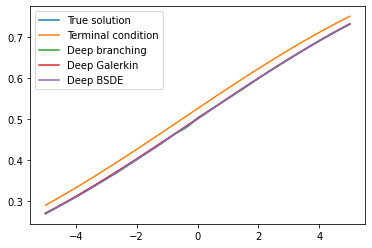

In [12]:
T=0.0750
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.67E-03; L2 error: 1.47E-05; rel error: 6.86E-03.
fdb runtime: 6 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 192 seconds; L1 error: 9.81E-04; L2 error: 1.26E-06; rel error: 2.40E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 1.22E-03; L2 error: 2.08E-06; rel error: 3.02E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 2.28E-03; L2 error: 8.74E-06; rel error: 5.32E-03.
fdb runtime: 10 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 180 seconds; L1 error: 1.53E-03; L2 error: 3.99E-06; rel error: 4.13E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 140 seconds; L1 error: 1.85E-03; L2 error: 4.53E-06; rel error: 4.05E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 1.78E-03; L2 error: 4.75E-06; rel error: 3.79E-03.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 185 seconds; L1 error: 7.25E-04; L2 error: 1.04E-06; rel error: 1.90E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 150 seconds; L1 error: 1.86E-03; L2 error: 5.02E-06; rel error: 4.65E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 1.49E-03; L2 error: 3.21E-06; rel error: 3.43E-03.
fdb runtime: 12 seconds; total runtime: 88 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 185 seconds; L1 error: 8.60E-04; L2 error: 9.44E-07; rel error: 1.66E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 143 seconds; L1 error: 1.12E-03; L2 error: 2.09E-06; rel error: 2.80E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 3.98E-03; L2 error: 5.04E-05; rel error: 9.19E-03.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 180 seconds; L1 error: 8.94E-04; L2 error: 1.19E-06; rel error: 2.21E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 149 seconds; L1 error: 6.98E-04; L2 error: 8.27E-07; rel error: 1.60E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 3.20E-03; L2 error: 1.57E-05; rel error: 7.43E-03.
fdb runtime: 11 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 190 seconds; L1 error: 9.78E-04; L2 error: 2.17E-06; rel error: 1.73E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 144 seconds; L1 error: 1.66E-03; L2 error: 4.19E-06; rel error: 3.73E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 1.66E-03; L2 error: 4.46E-06; rel error: 3.94E-03.
fdb runtime: 8 seconds; total runtime: 79 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 186 seconds; L1 error: 1.84E-03; L2 error: 5.08E-06; rel error: 4.70E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 143 seconds; L1 error: 2.15E-03; L2 error: 6.86E-06; rel error: 4.14E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 1.97E-03; L2 error: 4.98E-06; rel error: 4.63E-03.
fdb runtime: 10 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 186 seconds; L1 error: 3.10E-03; L2 error: 1.12E-05; rel error: 6.26E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 147 seconds; L1 error: 2.07E-03; L2 error: 6.06E-06; rel error: 5.17E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.60E-03; L2 error: 4.41E-06; rel error: 3.30E-03.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 182 seconds; L1 error: 7.35E-04; L2 error: 7.34E-07; rel error: 1.79E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 143 seconds; L1 error: 1.85E-03; L2 error: 4.05E-06; rel error: 4.05E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 3.04E-03; L2 error: 1.40E-05; rel error: 6.82E-03.
fdb runtime: 8 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 184 seconds; L1 error: 1.59E-03; L2 error: 3.58E-06; rel error: 4.07E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 140 seconds; L1 error: 1.50E-03; L2 error: 3.60E-06; rel error: 3.10E-03.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  82
mean L1 error:  2.37E-03
std L1 error:   7.89E-04
mean L2 error:  1.25E-05
std L2 error:   1.34E-05
mean rel error: 5.47E-03
std rel error:  1.90E-03


######## Summary for deep galerkin method
runtime:        185
mean L1 error:  1.32E-03
std L1 error:   7.00E-04
mean L2 error:  3.12E-06
std L2 error:   3.06E-06
mean rel error: 3.09E-03
std rel error:  1.51E-03


######## Summary for deep BSDE method
runtime:        144
mean L1 error:  1.60E-03
std L1 e

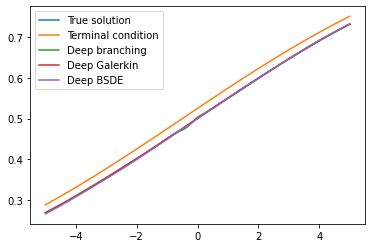

In [13]:
T=0.0875
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.12E-03; L2 error: 5.87E-06; rel error: 4.93E-03.
fdb runtime: 6 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 179 seconds; L1 error: 9.26E-04; L2 error: 1.15E-06; rel error: 2.28E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 1.72E-03; L2 error: 4.13E-06; rel error: 3.86E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 2.96E-03; L2 error: 1.64E-05; rel error: 6.93E-03.
fdb runtime: 10 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 189 seconds; L1 error: 1.46E-03; L2 error: 3.58E-06; rel error: 3.92E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 1.42E-03; L2 error: 2.83E-06; rel error: 2.86E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 2.12E-03; L2 error: 7.03E-06; rel error: 4.54E-03.
fdb runtime: 8 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 178 seconds; L1 error: 7.38E-04; L2 error: 1.08E-06; rel error: 1.94E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 143 seconds; L1 error: 2.47E-03; L2 error: 8.25E-06; rel error: 5.92E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 1.72E-03; L2 error: 4.55E-06; rel error: 4.02E-03.
fdb runtime: 12 seconds; total runtime: 89 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 179 seconds; L1 error: 8.39E-04; L2 error: 8.99E-07; rel error: 1.62E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 146 seconds; L1 error: 2.77E-03; L2 error: 1.02E-05; rel error: 6.68E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 5.13E-03; L2 error: 8.89E-05; rel error: 1.19E-02.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 187 seconds; L1 error: 8.71E-04; L2 error: 1.13E-06; rel error: 2.15E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 145 seconds; L1 error: 1.55E-03; L2 error: 3.55E-06; rel error: 3.62E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 4.21E-03; L2 error: 2.80E-05; rel error: 9.70E-03.
fdb runtime: 11 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 184 seconds; L1 error: 9.76E-04; L2 error: 2.20E-06; rel error: 1.72E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 144 seconds; L1 error: 1.83E-03; L2 error: 5.41E-06; rel error: 4.78E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 1.99E-03; L2 error: 6.30E-06; rel error: 4.66E-03.
fdb runtime: 8 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 191 seconds; L1 error: 1.79E-03; L2 error: 4.82E-06; rel error: 4.58E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 148 seconds; L1 error: 1.61E-03; L2 error: 4.87E-06; rel error: 4.42E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 2.63E-03; L2 error: 9.50E-06; rel error: 6.39E-03.
fdb runtime: 10 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 190 seconds; L1 error: 2.92E-03; L2 error: 1.01E-05; rel error: 5.87E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 148 seconds; L1 error: 2.01E-03; L2 error: 6.59E-06; rel error: 5.33E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.95E-03; L2 error: 6.82E-06; rel error: 4.03E-03.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 178 seconds; L1 error: 7.31E-04; L2 error: 7.26E-07; rel error: 1.78E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 147 seconds; L1 error: 1.44E-03; L2 error: 3.18E-06; rel error: 2.57E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 2.84E-03; L2 error: 1.01E-05; rel error: 6.14E-03.
fdb runtime: 7 seconds; total runtime: 74 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 185 seconds; L1 error: 1.61E-03; L2 error: 3.68E-06; rel error: 4.12E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 147 seconds; L1 error: 1.92E-03; L2 error: 4.57E-06; rel error: 3.93E-03.




######## Summary for deep branching method
runtime:        71
fdb runtime:    9
total runtime:  80
mean L1 error:  2.77E-03
std L1 error:   1.05E-03
mean L2 error:  1.83E-05
std L2 error:   2.44E-05
mean rel error: 6.32E-03
std rel error:  2.47E-03


######## Summary for deep galerkin method
runtime:        184
mean L1 error:  1.29E-03
std L1 error:   6.54E-04
mean L2 error:  2.93E-06
std L2 error:   2.73E-06
mean rel error: 3.00E-03
std rel error:  1.42E-03


######## Summary for deep BSDE method
runtime:        146
mean L1 error:  1.87E-03
std L1 e

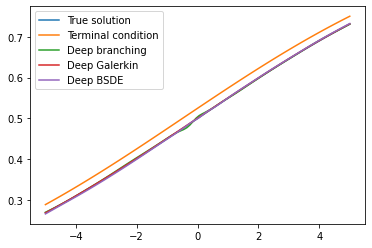

In [14]:
T=0.10
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 4.41E-03; L2 error: 2.83E-05; rel error: 9.88E-03.
fdb runtime: 6 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 176 seconds; L1 error: 6.96E-04; L2 error: 8.08E-07; rel error: 1.79E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 141 seconds; L1 error: 3.28E-03; L2 error: 1.70E-05; rel error: 8.01E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 5.88E-03; L2 error: 6.06E-05; rel error: 1.36E-02.
fdb runtime: 10 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 178 seconds; L1 error: 1.13E-03; L2 error: 1.99E-06; rel error: 2.94E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 3.18E-03; L2 error: 1.26E-05; rel error: 6.97E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 4.43E-03; L2 error: 3.41E-05; rel error: 9.39E-03.
fdb runtime: 9 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 186 seconds; L1 error: 8.42E-04; L2 error: 1.40E-06; rel error: 2.18E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 3.41E-03; L2 error: 1.56E-05; rel error: 8.34E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 3.23E-03; L2 error: 1.81E-05; rel error: 7.86E-03.
fdb runtime: 12 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 186 seconds; L1 error: 7.64E-04; L2 error: 7.53E-07; rel error: 1.47E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 2.90E-03; L2 error: 1.21E-05; rel error: 7.39E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 7.26E-03; L2 error: 1.33E-04; rel error: 1.77E-02.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 182 seconds; L1 error: 7.93E-04; L2 error: 9.45E-07; rel error: 1.93E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 141 seconds; L1 error: 2.84E-03; L2 error: 1.15E-05; rel error: 7.11E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 6.69E-03; L2 error: 7.71E-05; rel error: 1.60E-02.
fdb runtime: 11 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 173 seconds; L1 error: 9.69E-04; L2 error: 2.30E-06; rel error: 1.68E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 142 seconds; L1 error: 2.29E-03; L2 error: 8.55E-06; rel error: 5.97E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 4.02E-03; L2 error: 2.42E-05; rel error: 9.36E-03.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 183 seconds; L1 error: 1.62E-03; L2 error: 3.87E-06; rel error: 4.12E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 129 seconds; L1 error: 3.56E-03; L2 error: 1.67E-05; rel error: 7.43E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 5.71E-03; L2 error: 4.33E-05; rel error: 1.39E-02.
fdb runtime: 10 seconds; total runtime: 76 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 179 seconds; L1 error: 2.22E-03; L2 error: 6.10E-06; rel error: 4.45E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 146 seconds; L1 error: 3.66E-03; L2 error: 1.97E-05; rel error: 9.37E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 4.67E-03; L2 error: 3.39E-05; rel error: 9.65E-03.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 181 seconds; L1 error: 7.09E-04; L2 error: 6.95E-07; rel error: 1.74E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 138 seconds; L1 error: 3.39E-03; L2 error: 1.38E-05; rel error: 7.58E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 6.46E-03; L2 error: 4.80E-05; rel error: 1.40E-02.
fdb runtime: 8 seconds; total runtime: 71 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 181 seconds; L1 error: 1.67E-03; L2 error: 4.10E-06; rel error: 4.29E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 136 seconds; L1 error: 2.60E-03; L2 error: 7.89E-06; rel error: 5.66E-03.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  81
mean L1 error:  5.28E-03
std L1 error:   1.24E-03
mean L2 error:  5.00E-05
std L2 error:   3.22E-05
mean rel error: 1.21E-02
std rel error:  3.16E-03


######## Summary for deep galerkin method
runtime:        180
mean L1 error:  1.14E-03
std L1 error:   4.94E-04
mean L2 error:  2.30E-06
std L2 error:   1.74E-06
mean rel error: 2.66E-03
std rel error:  1.13E-03


######## Summary for deep BSDE method
runtime:        141
mean L1 error:  3.11E-03
std L1 e

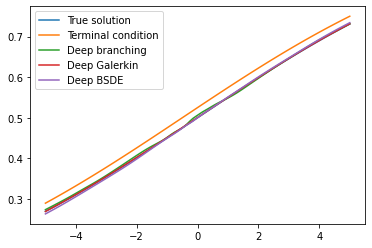

In [6]:
T=0.15
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 5.82E-03; L2 error: 5.56E-05; rel error: 1.32E-02.
fdb runtime: 6 seconds; total runtime: 79 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 193 seconds; L1 error: 5.49E-04; L2 error: 5.62E-07; rel error: 1.47E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 139 seconds; L1 error: 5.68E-03; L2 error: 4.13E-05; rel error: 1.35E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 6.90E-03; L2 error: 8.97E-05; rel error: 1.63E-02.
fdb runtime: 9 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 181 seconds; L1 error: 7.39E-04; L2 error: 7.69E-07; rel error: 1.81E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 5.21E-03; L2 error: 3.69E-05; rel error: 1.24E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 78 seconds; L1 error: 9.41E-03; L2 error: 1.73E-04; rel error: 2.04E-02.
fdb runtime: 9 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 181 seconds; L1 error: 1.06E-03; L2 error: 1.88E-06; rel error: 2.69E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 151 seconds; L1 error: 4.55E-03; L2 error: 3.11E-05; rel error: 1.16E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 5.01E-03; L2 error: 4.33E-05; rel error: 1.23E-02.
fdb runtime: 12 seconds; total runtime: 90 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 176 seconds; L1 error: 7.03E-04; L2 error: 6.44E-07; rel error: 1.35E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 143 seconds; L1 error: 5.01E-03; L2 error: 3.18E-05; rel error: 1.21E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 79 seconds; L1 error: 8.63E-03; L2 error: 1.46E-04; rel error: 2.18E-02.
fdb runtime: 8 seconds; total runtime: 88 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 190 seconds; L1 error: 7.31E-04; L2 error: 8.24E-07; rel error: 1.77E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 146 seconds; L1 error: 4.09E-03; L2 error: 2.63E-05; rel error: 1.02E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 1.16E-02; L2 error: 2.34E-04; rel error: 2.77E-02.
fdb runtime: 11 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 186 seconds; L1 error: 9.58E-04; L2 error: 2.41E-06; rel error: 1.62E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 4.51E-03; L2 error: 3.04E-05; rel error: 1.13E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 6.57E-03; L2 error: 6.14E-05; rel error: 1.53E-02.
fdb runtime: 8 seconds; total runtime: 75 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 178 seconds; L1 error: 1.47E-03; L2 error: 3.04E-06; rel error: 3.69E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 137 seconds; L1 error: 3.63E-03; L2 error: 1.62E-05; rel error: 8.17E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 58 seconds; L1 error: 8.92E-03; L2 error: 1.09E-04; rel error: 2.20E-02.
fdb runtime: 9 seconds; total runtime: 68 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 182 seconds; L1 error: 1.61E-03; L2 error: 3.37E-06; rel error: 3.23E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 142 seconds; L1 error: 4.64E-03; L2 error: 3.32E-05; rel error: 1.19E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 7.97E-03; L2 error: 1.23E-04; rel error: 1.71E-02.
fdb runtime: 8 seconds; total runtime: 67 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 182 seconds; L1 error: 6.87E-04; L2 error: 6.61E-07; rel error: 1.70E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 144 seconds; L1 error: 4.79E-03; L2 error: 2.95E-05; rel error: 1.12E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 8.90E-03; L2 error: 9.99E-05; rel error: 2.10E-02.
fdb runtime: 7 seconds; total runtime: 75 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 192 seconds; L1 error: 1.72E-03; L2 error: 4.51E-06; rel error: 4.45E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 149 seconds; L1 error: 4.45E-03; L2 error: 2.49E-05; rel error: 1.02E-02.




######## Summary for deep branching method
runtime:        71
fdb runtime:    9
total runtime:  80
mean L1 error:  7.97E-03
std L1 error:   1.84E-03
mean L2 error:  1.13E-04
std L2 error:   5.56E-05
mean rel error: 1.87E-02
std rel error:  4.49E-03


######## Summary for deep galerkin method
runtime:        184
mean L1 error:  1.02E-03
std L1 error:   4.04E-04
mean L2 error:  1.87E-06
std L2 error:   1.34E-06
mean rel error: 2.38E-03
std rel error:  1.02E-03


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  4.66E-03
std L1 e

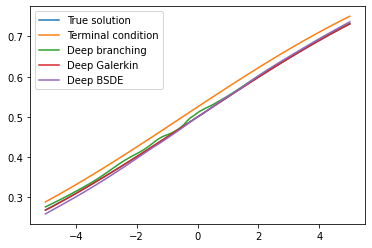

In [6]:
T=0.20
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 9.46E-03; L2 error: 1.58E-04; rel error: 2.31E-02.
fdb runtime: 6 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 184 seconds; L1 error: 4.98E-04; L2 error: 4.36E-07; rel error: 1.32E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 149 seconds; L1 error: 9.07E-03; L2 error: 9.96E-05; rel error: 2.17E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.13E-02; L2 error: 1.79E-04; rel error: 2.60E-02.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 183 seconds; L1 error: 4.03E-04; L2 error: 2.09E-07; rel error: 8.53E-04.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 150 seconds; L1 error: 5.79E-03; L2 error: 4.87E-05; rel error: 1.41E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 1.03E-02; L2 error: 1.68E-04; rel error: 2.27E-02.
fdb runtime: 9 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 181 seconds; L1 error: 1.34E-03; L2 error: 2.53E-06; rel error: 3.32E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 145 seconds; L1 error: 6.23E-03; L2 error: 5.86E-05; rel error: 1.59E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 8.32E-03; L2 error: 1.11E-04; rel error: 2.08E-02.
fdb runtime: 12 seconds; total runtime: 88 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 195 seconds; L1 error: 6.52E-04; L2 error: 5.59E-07; rel error: 1.25E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 147 seconds; L1 error: 5.26E-03; L2 error: 4.59E-05; rel error: 1.40E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 78 seconds; L1 error: 1.13E-02; L2 error: 2.32E-04; rel error: 2.59E-02.
fdb runtime: 8 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 190 seconds; L1 error: 6.95E-04; L2 error: 7.69E-07; rel error: 1.67E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 137 seconds; L1 error: 5.86E-03; L2 error: 4.84E-05; rel error: 1.46E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 1.44E-02; L2 error: 2.81E-04; rel error: 3.50E-02.
fdb runtime: 11 seconds; total runtime: 76 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 189 seconds; L1 error: 9.47E-04; L2 error: 2.51E-06; rel error: 1.56E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 152 seconds; L1 error: 6.43E-03; L2 error: 5.89E-05; rel error: 1.63E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 8.63E-03; L2 error: 1.14E-04; rel error: 1.92E-02.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 187 seconds; L1 error: 1.36E-03; L2 error: 2.39E-06; rel error: 3.32E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 143 seconds; L1 error: 6.07E-03; L2 error: 4.41E-05; rel error: 1.37E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 78 seconds; L1 error: 1.30E-02; L2 error: 2.33E-04; rel error: 3.20E-02.
fdb runtime: 9 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 182 seconds; L1 error: 1.10E-03; L2 error: 1.69E-06; rel error: 2.25E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 152 seconds; L1 error: 6.28E-03; L2 error: 6.15E-05; rel error: 1.58E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 9.13E-03; L2 error: 1.32E-04; rel error: 2.10E-02.
fdb runtime: 8 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 172 seconds; L1 error: 6.66E-04; L2 error: 6.31E-07; rel error: 1.66E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 148 seconds; L1 error: 6.49E-03; L2 error: 5.77E-05; rel error: 1.56E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 1.39E-02; L2 error: 2.44E-04; rel error: 3.27E-02.
fdb runtime: 7 seconds; total runtime: 75 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 170 seconds; L1 error: 1.77E-03; L2 error: 4.93E-06; rel error: 4.60E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 151 seconds; L1 error: 5.39E-03; L2 error: 4.14E-05; rel error: 1.32E-02.




######## Summary for deep branching method
runtime:        74
fdb runtime:    9
total runtime:  83
mean L1 error:  1.10E-02
std L1 error:   2.07E-03
mean L2 error:  1.85E-04
std L2 error:   5.62E-05
mean rel error: 2.58E-02
std rel error:  5.30E-03


######## Summary for deep galerkin method
runtime:        183
mean L1 error:  9.43E-04
std L1 error:   4.18E-04
mean L2 error:  1.66E-06
std L2 error:   1.39E-06
mean rel error: 2.18E-03
std rel error:  1.13E-03


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  6.29E-03
std L1 e

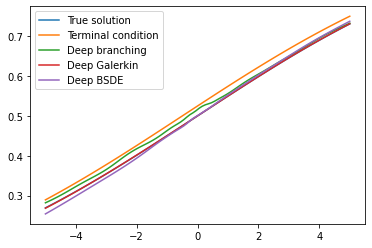

In [7]:
T=0.25
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 1.29E-02; L2 error: 3.08E-04; rel error: 3.17E-02.
fdb runtime: 6 seconds; total runtime: 72 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 187 seconds; L1 error: 5.54E-04; L2 error: 4.62E-07; rel error: 1.36E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 149 seconds; L1 error: 9.31E-03; L2 error: 1.28E-04; rel error: 2.28E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 1.50E-02; L2 error: 3.25E-04; rel error: 3.42E-02.
fdb runtime: 9 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 184 seconds; L1 error: 6.12E-04; L2 error: 5.31E-07; rel error: 1.46E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 143 seconds; L1 error: 7.82E-03; L2 error: 7.94E-05; rel error: 1.88E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 1.47E-02; L2 error: 3.37E-04; rel error: 3.22E-02.
fdb runtime: 9 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 189 seconds; L1 error: 1.60E-03; L2 error: 3.29E-06; rel error: 3.91E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 145 seconds; L1 error: 1.14E-02; L2 error: 1.67E-04; rel error: 2.80E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 79 seconds; L1 error: 1.32E-02; L2 error: 2.77E-04; rel error: 3.24E-02.
fdb runtime: 13 seconds; total runtime: 92 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 187 seconds; L1 error: 6.14E-04; L2 error: 4.99E-07; rel error: 1.18E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 147 seconds; L1 error: 9.26E-03; L2 error: 1.20E-04; rel error: 2.35E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 1.49E-02; L2 error: 3.99E-04; rel error: 3.39E-02.
fdb runtime: 8 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 183 seconds; L1 error: 6.83E-04; L2 error: 7.63E-07; rel error: 1.64E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 149 seconds; L1 error: 6.98E-03; L2 error: 7.62E-05; rel error: 1.79E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 2.02E-02; L2 error: 5.30E-04; rel error: 4.88E-02.
fdb runtime: 11 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 171 seconds; L1 error: 9.38E-04; L2 error: 2.62E-06; rel error: 1.50E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 145 seconds; L1 error: 8.82E-03; L2 error: 1.06E-04; rel error: 2.16E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 1.12E-02; L2 error: 1.99E-04; rel error: 2.48E-02.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 192 seconds; L1 error: 1.27E-03; L2 error: 1.94E-06; rel error: 3.00E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 161 seconds; L1 error: 7.34E-03; L2 error: 7.46E-05; rel error: 1.81E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 1.83E-02; L2 error: 4.40E-04; rel error: 4.37E-02.
fdb runtime: 10 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 196 seconds; L1 error: 7.36E-04; L2 error: 8.98E-07; rel error: 1.55E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 154 seconds; L1 error: 8.97E-03; L2 error: 1.14E-04; rel error: 2.22E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 1.30E-02; L2 error: 2.49E-04; rel error: 3.05E-02.
fdb runtime: 8 seconds; total runtime: 70 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 180 seconds; L1 error: 6.47E-04; L2 error: 6.00E-07; rel error: 1.61E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 153 seconds; L1 error: 9.09E-03; L2 error: 1.13E-04; rel error: 2.23E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 82 seconds; L1 error: 1.96E-02; L2 error: 4.90E-04; rel error: 4.62E-02.
fdb runtime: 8 seconds; total runtime: 89 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 193 seconds; L1 error: 1.83E-03; L2 error: 5.37E-06; rel error: 4.77E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 157 seconds; L1 error: 9.08E-03; L2 error: 1.03E-04; rel error: 2.16E-02.




######## Summary for deep branching method
runtime:        73
fdb runtime:    9
total runtime:  82
mean L1 error:  1.53E-02
std L1 error:   2.90E-03
mean L2 error:  3.56E-04
std L2 error:   1.01E-04
mean rel error: 3.59E-02
std rel error:  7.33E-03


######## Summary for deep galerkin method
runtime:        186
mean L1 error:  9.48E-04
std L1 error:   4.35E-04
mean L2 error:  1.70E-06
std L2 error:   1.55E-06
mean rel error: 2.20E-03
std rel error:  1.18E-03


######## Summary for deep BSDE method
runtime:        150
mean L1 error:  8.81E-03
std L1 e

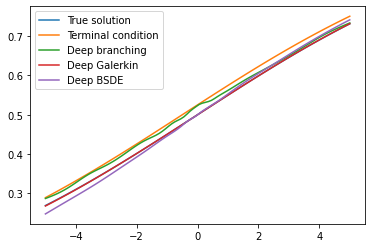

In [8]:
T=0.30
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 1.65E-02; L2 error: 5.22E-04; rel error: 4.06E-02.
fdb runtime: 6 seconds; total runtime: 72 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 192 seconds; L1 error: 7.13E-04; L2 error: 6.37E-07; rel error: 1.57E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 151 seconds; L1 error: 3.00E+00; L2 error: 2.16E+01; rel error: 8.71E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.09E-02; L2 error: 5.77E-04; rel error: 4.72E-02.
fdb runtime: 10 seconds; total runtime: 84 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 184 seconds; L1 error: 1.19E-03; L2 error: 1.85E-06; rel error: 2.98E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 155 seconds; L1 error: 1.06E-02; L2 error: 1.68E-04; rel error: 2.64E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 79 seconds; L1 error: 2.01E-02; L2 error: 6.75E-04; rel error: 4.46E-02.
fdb runtime: 9 seconds; total runtime: 88 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 188 seconds; L1 error: 1.84E-03; L2 error: 4.13E-06; rel error: 4.46E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 153 seconds; L1 error: 1.06E-02; L2 error: 1.63E-04; rel error: 2.67E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.63E-02; L2 error: 3.95E-04; rel error: 3.96E-02.
fdb runtime: 13 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 186 seconds; L1 error: 5.87E-04; L2 error: 4.61E-07; rel error: 1.13E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 157 seconds; L1 error: 1.18E-02; L2 error: 1.98E-04; rel error: 2.93E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 79 seconds; L1 error: 1.89E-02; L2 error: 6.99E-04; rel error: 4.19E-02.
fdb runtime: 8 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 183 seconds; L1 error: 6.96E-04; L2 error: 8.02E-07; rel error: 1.66E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 148 seconds; L1 error: 1.03E-02; L2 error: 1.71E-04; rel error: 2.69E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 2.36E-02; L2 error: 7.21E-04; rel error: 5.82E-02.
fdb runtime: 11 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 189 seconds; L1 error: 9.50E-04; L2 error: 2.76E-06; rel error: 1.49E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 148 seconds; L1 error: 1.14E-02; L2 error: 1.88E-04; rel error: 2.88E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 1.28E-02; L2 error: 2.14E-04; rel error: 2.73E-02.
fdb runtime: 9 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 176 seconds; L1 error: 1.22E-03; L2 error: 1.69E-06; rel error: 2.73E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 149 seconds; L1 error: 1.15E-02; L2 error: 1.51E-04; rel error: 2.61E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 81 seconds; L1 error: 2.14E-02; L2 error: 6.16E-04; rel error: 5.21E-02.
fdb runtime: 10 seconds; total runtime: 91 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 198 seconds; L1 error: 6.89E-04; L2 error: 7.61E-07; rel error: 1.51E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 151 seconds; L1 error: 1.15E-02; L2 error: 1.88E-04; rel error: 2.88E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 1.78E-02; L2 error: 4.70E-04; rel error: 4.23E-02.
fdb runtime: 8 seconds; total runtime: 84 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 192 seconds; L1 error: 6.31E-04; L2 error: 5.72E-07; rel error: 1.57E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 152 seconds; L1 error: 1.24E-02; L2 error: 2.00E-04; rel error: 3.02E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 72 seconds; L1 error: 2.65E-02; L2 error: 9.04E-04; rel error: 6.18E-02.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 182 seconds; L1 error: 1.90E-03; L2 error: 5.81E-06; rel error: 4.94E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 146 seconds; L1 error: 1.40E+00; L2 error: 1.18E+01; rel error: 4.71E+00.




######## Summary for deep branching method
runtime:        75
fdb runtime:    9
total runtime:  84
mean L1 error:  1.95E-02
std L1 error:   3.73E-03
mean L2 error:  5.79E-04
std L2 error:   1.82E-04
mean rel error: 4.56E-02
std rel error:  9.41E-03


######## Summary for deep galerkin method
runtime:        187
mean L1 error:  1.04E-03
std L1 error:   4.64E-04
mean L2 error:  1.95E-06
std L2 error:   1.70E-06
mean rel error: 2.40E-03
std rel error:  1.28E-03


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  4.49E-01
std L1 e

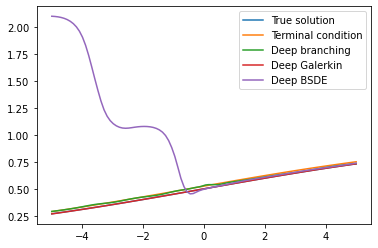

In [9]:
T=0.35
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.79E-02; L2 error: 5.23E-04; rel error: 4.58E-02.
fdb runtime: 6 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 184 seconds; L1 error: 8.88E-04; L2 error: 9.57E-07; rel error: 1.83E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 141 seconds; L1 error: 1.05E+01; L2 error: 1.15E+02; rel error: 2.32E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 2.48E-02; L2 error: 8.16E-04; rel error: 5.63E-02.
fdb runtime: 10 seconds; total runtime: 81 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 190 seconds; L1 error: 1.78E-03; L2 error: 4.17E-06; rel error: 4.52E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 150 seconds; L1 error: 7.53E+00; L2 error: 7.66E+01; rel error: 1.91E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.39E-02; L2 error: 1.06E-03; rel error: 5.34E-02.
fdb runtime: 9 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 173 seconds; L1 error: 2.07E-03; L2 error: 5.02E-06; rel error: 4.96E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 151 seconds; L1 error: 1.55E-02; L2 error: 4.10E-04; rel error: 4.05E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 80 seconds; L1 error: 1.92E-02; L2 error: 5.46E-04; rel error: 4.56E-02.
fdb runtime: 13 seconds; total runtime: 93 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 190 seconds; L1 error: 5.68E-04; L2 error: 4.32E-07; rel error: 1.09E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 1.94E+01; L2 error: 3.93E+02; rel error: 4.33E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 2.23E-02; L2 error: 9.83E-04; rel error: 4.88E-02.
fdb runtime: 8 seconds; total runtime: 79 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 184 seconds; L1 error: 7.29E-04; L2 error: 8.78E-07; rel error: 1.74E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 140 seconds; L1 error: 3.06E+00; L2 error: 1.16E+01; rel error: 5.82E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 2.99E-02; L2 error: 1.13E-03; rel error: 7.34E-02.
fdb runtime: 12 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 182 seconds; L1 error: 1.03E-03; L2 error: 2.95E-06; rel error: 1.72E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 131 seconds; L1 error: 1.34E-02; L2 error: 2.67E-04; rel error: 3.42E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 1.52E-02; L2 error: 3.12E-04; rel error: 3.23E-02.
fdb runtime: 8 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 187 seconds; L1 error: 1.19E-03; L2 error: 1.65E-06; rel error: 2.51E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 146 seconds; L1 error: 1.40E+01; L2 error: 2.13E+02; rel error: 3.21E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 2.64E-02; L2 error: 9.33E-04; rel error: 6.39E-02.
fdb runtime: 10 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 181 seconds; L1 error: 8.31E-04; L2 error: 1.05E-06; rel error: 1.86E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 152 seconds; L1 error: 1.41E-02; L2 error: 2.83E-04; rel error: 3.49E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 2.21E-02; L2 error: 7.02E-04; rel error: 5.35E-02.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 184 seconds; L1 error: 6.18E-04; L2 error: 5.45E-07; rel error: 1.53E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 146 seconds; L1 error: 1.35E+01; L2 error: 1.90E+02; rel error: 2.95E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 68 seconds; L1 error: 3.06E-02; L2 error: 1.15E-03; rel error: 7.20E-02.
fdb runtime: 7 seconds; total runtime: 76 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 191 seconds; L1 error: 1.97E-03; L2 error: 6.30E-06; rel error: 5.14E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 155 seconds; L1 error: 1.53E+01; L2 error: 2.37E+02; rel error: 3.28E+01.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  81
mean L1 error:  2.32E-02
std L1 error:   4.72E-03
mean L2 error:  8.15E-04
std L2 error:   2.72E-04
mean rel error: 5.45E-02
std rel error:  1.20E-02


######## Summary for deep galerkin method
runtime:        185
mean L1 error:  1.17E-03
std L1 error:   5.39E-04
mean L2 error:  2.40E-06
std L2 error:   1.99E-06
mean rel error: 2.69E-03
std rel error:  1.47E-03


######## Summary for deep BSDE method
runtime:        146
mean L1 error:  8.34E+00
std L1 e

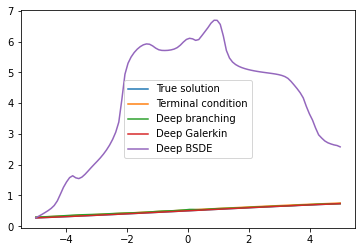

In [10]:
T=0.40
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 1.89E-02; L2 error: 5.75E-04; rel error: 4.76E-02.
fdb runtime: 6 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 186 seconds; L1 error: 1.07E-03; L2 error: 1.41E-06; rel error: 2.12E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 157 seconds; L1 error: 7.84E+00; L2 error: 6.33E+01; rel error: 1.67E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 77 seconds; L1 error: 2.90E-02; L2 error: 1.11E-03; rel error: 6.63E-02.
fdb runtime: 10 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 191 seconds; L1 error: 2.37E-03; L2 error: 7.39E-06; rel error: 6.02E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 153 seconds; L1 error: 5.23E+00; L2 error: 2.84E+01; rel error: 1.12E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 2.98E-02; L2 error: 1.81E-03; rel error: 6.64E-02.
fdb runtime: 9 seconds; total runtime: 83 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 186 seconds; L1 error: 2.27E-03; L2 error: 5.90E-06; rel error: 5.40E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 150 seconds; L1 error: 4.89E+00; L2 error: 2.51E+01; rel error: 1.10E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 2.56E-02; L2 error: 1.16E-03; rel error: 5.88E-02.
fdb runtime: 13 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 186 seconds; L1 error: 5.58E-04; L2 error: 4.14E-07; rel error: 1.07E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 158 seconds; L1 error: 7.42E+00; L2 error: 5.99E+01; rel error: 1.66E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.52E-02; L2 error: 9.95E-04; rel error: 5.66E-02.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 187 seconds; L1 error: 7.82E-04; L2 error: 1.00E-06; rel error: 1.88E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 156 seconds; L1 error: 4.99E+00; L2 error: 2.76E+01; rel error: 1.05E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 75 seconds; L1 error: 3.48E-02; L2 error: 1.48E-03; rel error: 8.31E-02.
fdb runtime: 11 seconds; total runtime: 87 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 187 seconds; L1 error: 1.14E-03; L2 error: 3.22E-06; rel error: 2.00E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 145 seconds; L1 error: 1.21E+01; L2 error: 1.48E+02; rel error: 2.70E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 70 seconds; L1 error: 1.82E-02; L2 error: 4.26E-04; rel error: 4.03E-02.
fdb runtime: 8 seconds; total runtime: 79 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 186 seconds; L1 error: 1.20E-03; L2 error: 1.85E-06; rel error: 2.35E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 131 seconds; L1 error: 9.66E+00; L2 error: 1.09E+02; rel error: 2.31E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 3.16E-02; L2 error: 1.31E-03; rel error: 7.58E-02.
fdb runtime: 10 seconds; total runtime: 76 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 185 seconds; L1 error: 1.04E-03; L2 error: 1.57E-06; rel error: 2.27E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 139 seconds; L1 error: 2.72E+01; L2 error: 7.49E+02; rel error: 5.92E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 71 seconds; L1 error: 2.94E-02; L2 error: 1.22E-03; rel error: 7.06E-02.
fdb runtime: 8 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 192 seconds; L1 error: 6.09E-04; L2 error: 5.24E-07; rel error: 1.50E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 141 seconds; L1 error: 8.47E+00; L2 error: 7.86E+01; rel error: 1.70E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 2.98E-02; L2 error: 1.24E-03; rel error: 6.98E-02.
fdb runtime: 7 seconds; total runtime: 73 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 192 seconds; L1 error: 2.04E-03; L2 error: 6.74E-06; rel error: 5.31E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 148 seconds; L1 error: 1.34E+01; L2 error: 1.83E+02; rel error: 2.94E+01.




######## Summary for deep branching method
runtime:        72
fdb runtime:    9
total runtime:  81
mean L1 error:  2.72E-02
std L1 error:   5.04E-03
mean L2 error:  1.13E-03
std L2 error:   3.83E-04
mean rel error: 6.35E-02
std rel error:  1.23E-02


######## Summary for deep galerkin method
runtime:        188
mean L1 error:  1.31E-03
std L1 error:   6.39E-04
mean L2 error:  3.00E-06
std L2 error:   2.54E-06
mean rel error: 2.99E-03
std rel error:  1.74E-03


######## Summary for deep BSDE method
runtime:        148
mean L1 error:  1.01E+01
std L1 e

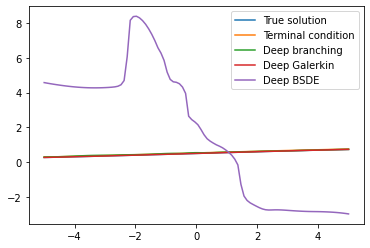

In [11]:
T=0.45
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 73 seconds; L1 error: 2.31E-02; L2 error: 7.74E-04; rel error: 5.65E-02.
fdb runtime: 6 seconds; total runtime: 79 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 192 seconds; L1 error: 1.27E-03; L2 error: 1.99E-06; rel error: 2.47E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 145 seconds; L1 error: 1.19E+01; L2 error: 1.67E+02; rel error: 2.28E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 69 seconds; L1 error: 2.66E-02; L2 error: 1.09E-03; rel error: 6.60E-02.
fdb runtime: 10 seconds; total runtime: 79 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 174 seconds; L1 error: 2.94E-03; L2 error: 1.13E-05; rel error: 7.45E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 153 seconds; L1 error: 6.16E+00; L2 error: 4.70E+01; rel error: 1.34E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 3.04E-02; L2 error: 2.01E-03; rel error: 6.82E-02.
fdb runtime: 9 seconds; total runtime: 84 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 187 seconds; L1 error: 2.46E-03; L2 error: 6.78E-06; rel error: 5.80E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 143 seconds; L1 error: 7.65E+00; L2 error: 6.20E+01; rel error: 1.63E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 2.37E-02; L2 error: 7.86E-04; rel error: 5.22E-02.
fdb runtime: 13 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 193 seconds; L1 error: 5.59E-04; L2 error: 4.07E-07; rel error: 1.08E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 155 seconds; L1 error: 6.09E+00; L2 error: 4.03E+01; rel error: 1.24E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 82 seconds; L1 error: 2.64E-02; L2 error: 1.21E-03; rel error: 5.98E-02.
fdb runtime: 9 seconds; total runtime: 90 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 194 seconds; L1 error: 8.55E-04; L2 error: 1.17E-06; rel error: 2.07E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 153 seconds; L1 error: 1.54E+01; L2 error: 2.94E+02; rel error: 2.95E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 80 seconds; L1 error: 3.81E-02; L2 error: 1.90E-03; rel error: 9.20E-02.
fdb runtime: 12 seconds; total runtime: 92 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 192 seconds; L1 error: 1.28E-03; L2 error: 3.64E-06; rel error: 2.38E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 151 seconds; L1 error: 8.17E+00; L2 error: 6.94E+01; rel error: 1.87E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 2.15E-02; L2 error: 5.39E-04; rel error: 4.82E-02.
fdb runtime: 8 seconds; total runtime: 70 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 168 seconds; L1 error: 1.24E-03; L2 error: 2.31E-06; rel error: 2.25E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 154 seconds; L1 error: 1.90E+01; L2 error: 3.91E+02; rel error: 4.07E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 76 seconds; L1 error: 3.24E-02; L2 error: 1.37E-03; rel error: 7.73E-02.
fdb runtime: 10 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 180 seconds; L1 error: 1.26E-03; L2 error: 2.07E-06; rel error: 2.64E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 150 seconds; L1 error: 1.64E+01; L2 error: 2.72E+02; rel error: 3.60E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 74 seconds; L1 error: 3.60E-02; L2 error: 1.93E-03; rel error: 8.68E-02.
fdb runtime: 8 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 195 seconds; L1 error: 6.08E-04; L2 error: 5.12E-07; rel error: 1.48E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 154 seconds; L1 error: 1.83E+01; L2 error: 3.56E+02; rel error: 4.24E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 78 seconds; L1 error: 4.08E-02; L2 error: 2.56E-03; rel error: 9.25E-02.
fdb runtime: 7 seconds; total runtime: 86 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 197 seconds; L1 error: 2.10E-03; L2 error: 7.12E-06; rel error: 5.47E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 153 seconds; L1 error: 2.31E+01; L2 error: 5.60E+02; rel error: 5.25E+01.




######## Summary for deep branching method
runtime:        74
fdb runtime:    9
total runtime:  83
mean L1 error:  2.99E-02
std L1 error:   6.38E-03
mean L2 error:  1.42E-03
std L2 error:   6.24E-04
mean rel error: 6.99E-02
std rel error:  1.56E-02


######## Summary for deep galerkin method
runtime:        187
mean L1 error:  1.46E-03
std L1 error:   7.52E-04
mean L2 error:  3.73E-06
std L2 error:   3.38E-06
mean rel error: 3.31E-03
std rel error:  2.03E-03


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  1.32E+01
std L1 e

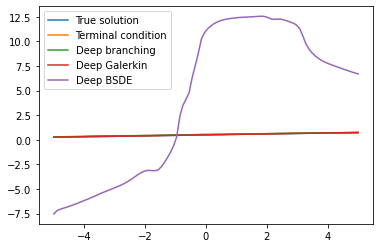

In [12]:
T=0.50
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)